In [1]:
#Math and Statistic
import numpy as np
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV, train_test_split, KFold

#Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tnrange, tqdm_notebook
from xgboost import plot_importance


#Future engineering
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from scipy.stats import uniform, randint

#Decision model
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

import inspect

In [40]:
import warnings
warnings.filterwarnings('ignore')

## Work with data

In [524]:
#make a test copy
df_player = pd.read_csv('FootballKaggleData/players.csv')
df_train_r = pd.read_csv('FootballKaggleData/train.csv', index_col = 'id')
df_test_r = pd.read_csv('FootballKaggleData/test.csv',  index_col = 'id')

#### BackUp data

In [525]:
df_train_fe = df_train_r[:]
df_player_fe = df_player[:]
df_test_fe = df_test_r[:]

In [526]:
df_train_fe.shape, df_test_fe.shape, df_player_fe.shape

((8786, 54), (7190, 53), (183978, 40))

###  Show me

In [527]:
df_player.head(2)

,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,finishing,heading_accuracy,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,505942,2016-02-18 00:00:00,67.0,71.0,right,medium,medium,49.0,44.0,71.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,505942,2015-11-19 00:00:00,67.0,71.0,right,medium,medium,49.0,44.0,71.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0


In [528]:
df_train_fe.head(2)

,home_player_1,home_player_2,home_player_3,home_player_4,home_player_5,home_player_6,home_player_7,home_player_8,home_player_9,home_player_10,...,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA,year,win_team
id,,,,,,,,,,,,,,,,,,,,,
0,25524,30668,27293,37787,25565,30598,30749,30987,21164,30496,...,3.75,6.50,1.44,3.75,8.0,1.44,3.75,7.0,2008,1
1,41671,18823,25526,46078,25587,181995,175646,177874,50189,32748,...,3.40,4.75,0.00,0.00,0.0,0.00,0.00,0.0,2016,0


In [529]:
df_test_fe.head(2)

,home_player_1,home_player_2,home_player_3,home_player_4,home_player_5,home_player_6,home_player_7,home_player_8,home_player_9,home_player_10,...,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA,year
id,,,,,,,,,,,,,,,,,,,,,
0,37421,56846,33960,282676,47565,102622,205278,75342,99047,184138,...,1.85,3.7,4.75,1.83,3.6,4.4,1.83,3.4,4.0,2012
1,150242,566158,157630,109649,40662,150119,278473,215226,207243,303059,...,1.13,9.0,21.00,0.00,0.0,0.0,0.00,0.0,0.0,2015


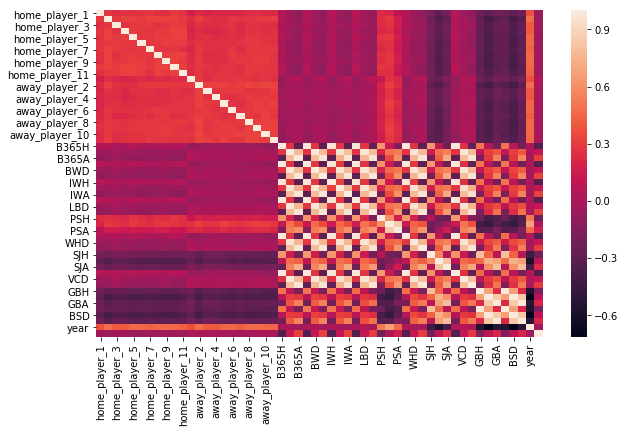

In [530]:
#Corelation matrix
data_corr=df_train_fe.corr()

plt.figure(figsize = (10,6))
sns.heatmap(data_corr)
pass

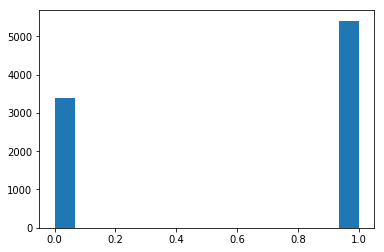

In [531]:
# target hist
plt.hist(df_train_fe.win_team, bins=15)
pass

### Convert to date format(only year)

In [133]:
df_player_fe['date'] = pd.to_datetime(df_player_fe['date'], format='%Y-%m-%d').apply(lambda x: x.year)
df_player_fe['date'][0]

2016

In [134]:
df_player_fe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183978 entries, 0 to 183977
Data columns (total 40 columns):
player_api_id          183978 non-null int64
date                   183978 non-null int64
overall_rating         183142 non-null float64
potential              183142 non-null float64
preferred_foot         183142 non-null object
attacking_work_rate    180748 non-null object
defensive_work_rate    183142 non-null object
crossing               183142 non-null float64
finishing              183142 non-null float64
heading_accuracy       183142 non-null float64
short_passing          183142 non-null float64
volleys                181265 non-null float64
dribbling              183142 non-null float64
curve                  181265 non-null float64
free_kick_accuracy     183142 non-null float64
long_passing           183142 non-null float64
ball_control           183142 non-null float64
acceleration           183142 non-null float64
sprint_speed           183142 non-null float64
agi

### Work with a categorical futures 

In [46]:
set(df_player_fe.preferred_foot), set(df_player_fe.attacking_work_rate)

({'left', nan, 'right'},
 {'None', 'high', 'le', 'low', 'medium', nan, 'norm', 'stoc', 'y'})

In [48]:
print(set(df_player_fe.defensive_work_rate))

{nan, '5', '3', '7', '6', '0', 'low', 'ean', '1', '_0', '8', '2', 'o', 'es', '9', '4', 'high', 'ormal', 'medium', 'tocky'}


#### Working with empty cells

In [135]:
df_player_fe = df_player_fe.fillna(df_player_fe.mean())

Filling categorical empty cells 

In [51]:
df_player_fe = df_player_fe.fillna('0')

Work with the categorical cells

In [52]:
one=OneHotEncoder(sparse=False)

one_hot_player = df_player_fe[['preferred_foot', 'attacking_work_rate', 'defensive_work_rate']]
one.fit(one_hot_player)

OneHotEncoder(categorical_features=None, categories=None,
       dtype=<class 'numpy.float64'>, handle_unknown='error',
       n_values=None, sparse=False)

In [53]:
one_hot_player = one.transform(one_hot_player.as_matrix())

#### Drop categorical columns and merge it back

In [137]:
df_player_fe = df_player_fe.drop(['preferred_foot', 'attacking_work_rate', 'defensive_work_rate'], axis=1)

In [138]:
df_player_fe.isnull().sum().sum()

0

### Get mean value of the player parameters and add to table(don't need anymore)

## Create average parameters of the team

Expamples part of code

#### Get mean parameters of team and put it on DataFrame

In [139]:
# sd = 0 for Home, 1 for away
def get_ha_team_aver(df_player_fe, df_train_fe, sd):
    team_aver = pd.DataFrame()
    
    

    #go through case
    for numb  in tqdm_notebook(range(0, df_train_fe.shape[0]), desc = 'Table row' ):
        team_player = pd.DataFrame() #create empty dataFrame
        game_year = df_train_fe.loc[numb]['year'] #get year
        player_in_team = list() # erase player id list
        
        #get player id 
        for i in range((0 if sd == 0 else 11), (11 if sd == 0 else 22)):
            player_in_team.append(int(df_train_fe.loc[numb][df_train_fe.columns[i]]))
    
        #collect player in team
        for player in player_in_team:
            team_player = team_player.append(df_player_fe[(df_player_fe['player_api_id'] == player)
                                        & (df_player_fe['date'] == game_year )].mean().append(
                                pd.Series(data = dict( side = sd))), ignore_index = True)
        #add mean team value in DataFrame
        team_aver = team_aver.append(team_player.drop(['player_api_id', 'date'], axis=1).mean().append(
                                pd.Series(data = dict( game_id =df_train_fe.index[numb]))), ignore_index = True)
    return team_aver

In [140]:
team_h_aver = get_ha_team_aver(df_player_fe, df_train_fe, 0) # 0 for Home, 1 for away
team_a_aver = get_ha_team_aver(df_player_fe, df_train_fe, 1) # 0 for Home, 1 for away

team_h_aver_test = get_ha_team_aver(df_player_fe, df_test_fe, 0) # 0 for Home, 1 for away
team_a_aver_test = get_ha_team_aver(df_player_fe, df_test_fe, 1) # 0 for Home, 1 for away

In [141]:
print (team_h_aver.isnull().sum().sum(), team_a_aver.isnull().sum().sum(), team_a_aver.shape, team_h_aver.shape)
print (team_h_aver_test.isnull().sum().sum(), team_a_aver_test.isnull().sum().sum(),
       team_a_aver_test.shape, team_h_aver_test.shape)

0 0 (8786, 37) (8786, 37)
0 0 (7190, 37) (7190, 37)


In [142]:
print (df_train_fe.isnull().sum().sum(), df_train_fe.shape)
print (df_test_fe.isnull().sum().sum(), df_test_fe.shape)

0 (8786, 54)
0 (7190, 53)


### Backup the data( yes, i like it)

In [143]:
df_train_fe_copy = df_train_fe[:]
df_test_fe_copy = df_test_fe[:]

team_h_aver_copy = team_h_aver[:]
team_a_aver_copy = team_a_aver[:]

team_h_aver_test_copy = team_h_aver_test[:]
team_a_aver_test_copy = team_a_aver_test[:]

If we need use backup

## We don't delete player id - rename DataFrame

In [144]:
train_with_team = df_train_fe[:]
train_with_team_test = df_test_fe[:]

## Try replace player ID to overall_rating without bound to year

Create mean of player table

In [145]:
df_player_fe_mean_c = tr = df_player_fe.groupby('player_api_id').mean()
df_player_fe_mean_c.reset_index(inplace=True)

In [146]:
df_player_fe_mean_c.head(2)

,player_api_id,date,overall_rating,potential,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,2625,2011.428571,60.142857,61.142857,50.142857,47.285714,46.285714,56.500000,38.000000,54.142857,...,55.285714,61.928571,62.928571,63.857143,56.571429,12.428571,12.857143,19.071429,10.357143,10.428571
1,2752,2012.333333,69.380952,70.380952,36.428571,37.428571,75.333333,54.809524,20.428571,44.857143,...,52.428571,35.428571,71.095238,70.666667,65.571429,11.095238,6.095238,7.095238,9.095238,15.095238


#### Replace id and overall_rating WITHOUT bound with the year function

In [147]:
def get_player_name_clear(df_train_fe):    
    #go trough case
    player_in_team = list()
    for numb  in tqdm_notebook(range(0, df_train_fe.shape[0]), desc = 'Get player'):
        #get player id 
        player_in_team.append(int(df_train_fe.loc[numb]['player_api_id']))
            
    return player_in_team   


            
def replace_id_to_over_clear(player_in_team, train_with_team, df_player_fe_mean_c):
         
    for player in tqdm_notebook(player_in_team, desc = 'Replace id to over'):
                
        train_with_team = train_with_team.replace(player,
                    float(df_player_fe_mean_c[df_player_fe_mean_c.player_api_id == player].overall_rating))
            
    return train_with_team

In [148]:
player_id_clear = get_player_name_clear(df_player_fe_mean_c)

Check to repeated values

In [149]:
len(player_id_clear), len(set(player_id_clear))

(11060, 11060)

In [150]:
train_wt_rep_cl = replace_id_to_over_clear(player_id_clear, train_with_team, df_player_fe_mean_c)

In [151]:
train_wt_rep_cl_test = replace_id_to_over_clear(player_id_clear, train_with_team_test, df_player_fe_mean_c)

In [152]:
train_wt_rep_cl.shape, train_wt_rep_cl_test.shape

((8786, 54), (7190, 53))

### Renaming if all was good

In [153]:
train_with_team = train_wt_rep_cl[:]
train_with_team_test = train_wt_rep_cl_test[:]

## Merge cases 

In [154]:
train_with_team = train_with_team.merge(team_h_aver, left_on='id', right_on='game_id', how = 'inner')

train_with_team_test = train_with_team_test.merge(team_h_aver_test, left_on='id', right_on='game_id', how = 'inner')

In [155]:
print(train_with_team.isnull().sum().sum(), train_with_team.shape)
print(train_with_team_test.isnull().sum().sum(), train_with_team_test.shape)

0 (8786, 91)
0 (7190, 90)


In [156]:
train_with_team = train_with_team.merge(team_a_aver, left_on='game_id', right_on='game_id', 
                                        how = 'inner', suffixes=('_h', '_h_'))

train_with_team_test = train_with_team_test.merge(team_a_aver_test, left_on='game_id', right_on='game_id', 
                                        how = 'inner', suffixes=('_h', '_h_'))

In [157]:
print(train_with_team.isnull().sum().sum(), train_with_team.shape)
print(train_with_team_test.isnull().sum().sum(), train_with_team_test.shape)

0 (8786, 127)
0 (7190, 126)


#### BackUp

In [158]:
train_with_team_c = train_with_team[:]
train_with_team_test_c = train_with_team_test[:]

In [159]:
train_with_team.shape, train_with_team_test.shape

((8786, 127), (7190, 126))

### Try replace player ID to overall_rating on the year(too long, need rewrote)

### Split data and target

In [533]:
train_with_team_copy = train_with_team[:]
train_with_team__test_copy = train_with_team_test[:]

y_train_with_team = train_with_team.win_team
y_train_with_team.head()
train_with_team.drop('win_team', axis=1, inplace=True)

#### Skaled it

In [534]:
ss = StandardScaler()

train_with_team = ss.fit_transform(train_with_team)
train_with_team_test = ss.fit_transform(train_with_team_test)

In [535]:
[train_with_team.min(), train_with_team.max()], [train_with_team_test.min(), train_with_team_test.max()]

([-6.641072533716706, 17.318820034449065],
 [-5.719084838867294, 12.79712300317556])

## Learning on the Test

### Split cases

In [567]:
X_train_wt, X_test_wt, Y_train_wt, Y_test_wt = train_test_split(train_with_team, y_train_with_team,
                                                   test_size = 0.2,
                                                   random_state=1)
X_train_wt, X_valid_wt, Y_train_wt, Y_valid_wt = train_test_split(X_train_wt, Y_train_wt, 
                                                                  test_size = 0.2, random_state = 1)
X_train_wt.shape, Y_train_wt.shape, X_test_wt.shape, Y_test_wt.shape, X_valid_wt.shape, Y_valid_wt.shape

((5622, 126), (5622,), (1758, 126), (1758,), (1406, 126), (1406,))

### Algorithm function

In [98]:
def xgb_model_fit(X_train, Y_train):
    xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=1)
    xgb_model.fit(X_train, Y_train)
    return xgb_model

def xgb_model_pred(xgb_model, X_train):
    xgb_model_pred_train = xgb_model.predict(X_train)
    return xgb_model_pred_train

def xgb_model_pred_proba(xgb_model, X_train):
    xgb_model_pred_train = xgb_model.predict_proba(X_train)[:,1]
    return xgb_model_pred_train
    
def roc_score_get(Y_train, xgb_model_pred_train):
    print('roc auc score: ', roc_auc_score(Y_train, xgb_model_pred_train))

In [99]:
def xgb_hyp_search_fit(xgb_model, X_train, Y_train, params, cv=3, n_iter=200, n_jobs=-1):   

    xgb_search = RandomizedSearchCV(xgb_model, param_distributions=params, random_state = 1,
                                   n_iter = n_iter, cv=cv, verbose = 1, 
                                    n_jobs = n_jobs, return_train_score=True)
    
    xgb_search.fit(X_train, Y_train)
    return(xgb_search)

In [561]:
def xgb_er_stop_fit(X_train, Y_train, eval_set, ear_stop_round=10, ev_metr = 'auc'):
    xgb_estop =xgb.XGBClassifier(objective='binary:logistic', random_state=1, eval_metric=ev_metr)    
    xgb_estop.fit(X_train, Y_train, early_stopping_rounds= ear_stop_round, eval_set=eval_set)
    return(xgb_estop)

In [101]:
def tree_class(X_train, Y_train):
    tree = DecisionTreeClassifier(max_depth = 2, min_samples_leaf = 1)
    tree.fit(X_train,Y_train)
    return tree

def grid_searchCV(tree, X_train, Y_train, param_grid, cv=10, n_jobs=-1):    
    grid_search = GridSearchCV(tree, param_grid, cv=cv,n_jobs = n_jobs)
    grid_search.fit(X_train, Y_train)
    return grid_search

## Let's Train

### Standart XGBOOST

In [537]:
xgb_m_wt = xgb_model_fit(X_train_wt, Y_train_wt)

In [538]:
xgb_m_wt_pred_tr = xgb_model_pred(xgb_m_wt, X_train_wt)
xgb_m_wt_pred_te = xgb_model_pred(xgb_m_wt, X_test_wt)
xgb_m_wt_pred_val = xgb_model_pred(xgb_m_wt, X_valid_wt)
xgb_m_wt_pred_fin = xgb_model_pred(xgb_m_wt, train_with_team_test)

xgb_m_wt_proba_tr = xgb_model_pred_proba(xgb_m_wt, X_train_wt)
xgb_m_wt_proba_te = xgb_model_pred_proba(xgb_m_wt, X_test_wt)
xgb_m_wt_proba_val = xgb_model_pred_proba(xgb_m_wt, X_valid_wt)
xgb_m_wt_proba_fin = xgb_model_pred_proba(xgb_m_wt, train_with_team_test)

In [539]:
print('Predict')
roc_score_get(Y_train_wt, xgb_m_wt_pred_tr)
roc_score_get(Y_test_wt, xgb_m_wt_pred_te)
roc_score_get(Y_valid_wt, xgb_m_wt_pred_val)
print('Predict_proba')
roc_score_get(Y_train_wt, xgb_m_wt_proba_tr)
roc_score_get(Y_test_wt, xgb_m_wt_proba_te)
roc_score_get(Y_valid_wt, xgb_m_wt_proba_val)

Predict
roc auc score:  0.7397249347142492
roc auc score:  0.6797874938935027
roc auc score:  0.6535408745247149
Predict_proba
roc auc score:  0.8515119104324257
roc auc score:  0.7659230309938665
roc auc score:  0.7403689941237469


### Randomized search xgb

In [540]:
xgb.XGBClassifier()

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [108]:
params_cv = {
          'colsample_bytree': np.arange(0.7, 1.0, 0.1),
          'gamma': np.arange(0.0001, 0.21, 0.1),
          'learning_rate': np.arange(0.06, 0.2, 0.01),
          'max_depth': np.arange(1,5, 1),
          'n_estimators': np.arange(90, 110, 1),
          'subsample':  np.arange(0.8, 1.0, 0.1)
             }

xgb_cv_wt = xgb_hyp_search_fit(xgb.XGBClassifier(objective='binary:logistic', random_state=1),
                               X_train_wt, Y_train_wt, params_cv, n_iter = 3000)

Fitting 3 folds for each of 3000 candidates, totalling 9000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   28.2s
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 438 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 788 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 1238 tasks      | elapsed: 11.1min
[Parallel(n_jobs=-1)]: Done 1788 tasks      | elapsed: 16.1min
[Parallel(n_jobs=-1)]: Done 2438 tasks      | elapsed: 21.8min
[Parallel(n_jobs=-1)]: Done 3188 tasks      | elapsed: 28.3min
[Parallel(n_jobs=-1)]: Done 4038 tasks      | elapsed: 35.8min
[Parallel(n_jobs=-1)]: Done 4988 tasks      | elapsed: 44.4min
[Parallel(n_jobs=-1)]: Done 6038 tasks      | elapsed: 53.8min
[Parallel(n_jobs=-1)]: Done 7188 tasks      | elapsed: 64.1min
[Parallel(n_jobs=-1)]: Done 8438 tasks      | elapsed: 75.6min
[Parallel(n_jobs=-1)]: Done 9000 out of 9000 | elapsed: 80.7min finished


In [109]:
xgb_cv_wt_pred_tr = xgb_model_pred(xgb_cv_wt, X_train_wt)
xgb_cv_wt_pred_te = xgb_model_pred(xgb_cv_wt, X_test_wt)
xgb_cv_wt_pred_val = xgb_model_pred(xgb_cv_wt, X_valid_wt)
xgb_cv_wt_pred_fin = xgb_model_pred(xgb_cv_wt, train_with_team_test)

xgb_cv_wt_proba_tr = xgb_model_pred_proba(xgb_cv_wt, X_train_wt)
xgb_cv_wt_proba_te = xgb_model_pred_proba(xgb_cv_wt, X_test_wt)
xgb_cv_wt_proba_val = xgb_model_pred_proba(xgb_cv_wt, X_valid_wt)
xgb_cv_wt_proba_fin = xgb_model_pred_proba(xgb_cv_wt, train_with_team_test)

In [110]:
print('Predict')
roc_score_get(Y_train_wt, xgb_cv_wt_pred_tr)
roc_score_get(Y_test_wt, xgb_cv_wt_pred_te)
roc_score_get(Y_valid_wt, xgb_cv_wt_pred_val)
print('Predict_proba')
roc_score_get(Y_train_wt, xgb_cv_wt_proba_tr)
roc_score_get(Y_test_wt, xgb_cv_wt_proba_te)
roc_score_get(Y_valid_wt, xgb_cv_wt_proba_val)

Predict
roc auc score:  0.6813158428910352
roc auc score:  0.684247325026414
roc auc score:  0.6609858127142518
Predict_proba
roc auc score:  0.7822346227415129
roc auc score:  0.766132915229548
roc auc score:  0.7531225604996097


In [111]:
xgb_cv_wt.best_params_

{'subsample': 0.8,
 'n_estimators': 91,
 'max_depth': 1,
 'learning_rate': 0.15999999999999995,
 'gamma': 0.2001,
 'colsample_bytree': 0.7999999999999999}

### XGBooster GridSearchCV ( too long)

### Booster Early stop

In [568]:
xgb_es_wt = xgb_er_stop_fit(X_train_wt, Y_train_wt, ear_stop_round = 110, eval_set=[(X_test_wt, Y_test_wt)])

[0]	validation_0-auc:0.741975
Will train until validation_0-auc hasn't improved in 110 rounds.
[1]	validation_0-auc:0.747689
[2]	validation_0-auc:0.749847
[3]	validation_0-auc:0.750579
[4]	validation_0-auc:0.750657
[5]	validation_0-auc:0.753637
[6]	validation_0-auc:0.756227
[7]	validation_0-auc:0.757708
[8]	validation_0-auc:0.75743
[9]	validation_0-auc:0.758317
[10]	validation_0-auc:0.757859
[11]	validation_0-auc:0.758999
[12]	validation_0-auc:0.759957
[13]	validation_0-auc:0.760801
[14]	validation_0-auc:0.760355
[15]	validation_0-auc:0.760838
[16]	validation_0-auc:0.761666
[17]	validation_0-auc:0.762664
[18]	validation_0-auc:0.763256
[19]	validation_0-auc:0.763441
[20]	validation_0-auc:0.763376
[21]	validation_0-auc:0.764954
[22]	validation_0-auc:0.764638
[23]	validation_0-auc:0.763992
[24]	validation_0-auc:0.763856
[25]	validation_0-auc:0.764324
[26]	validation_0-auc:0.764289
[27]	validation_0-auc:0.765253
[28]	validation_0-auc:0.765658
[29]	validation_0-auc:0.765878
[30]	validation_

In [569]:
xgb_es_wt_pred_tr = xgb_model_pred(xgb_es_wt, X_train_wt)
xgb_es_wt_pred_te = xgb_model_pred(xgb_es_wt, X_test_wt)
xgb_es_wt_pred_val = xgb_model_pred(xgb_es_wt, X_valid_wt)
xgb_es_wt_pred_fin = xgb_model_pred(xgb_es_wt, train_with_team_test)

xgb_es_wt_proba_tr = xgb_model_pred_proba(xgb_es_wt, X_train_wt)
xgb_es_wt_proba_te = xgb_model_pred_proba(xgb_es_wt, X_test_wt)
xgb_es_wt_proba_val = xgb_model_pred_proba(xgb_es_wt, X_valid_wt)
xgb_es_wt_proba_fin = xgb_model_pred_proba(xgb_es_wt, train_with_team_test)

In [570]:
print('Predict')
roc_score_get(Y_train_wt, xgb_es_wt_pred_tr)
roc_score_get(Y_test_wt, xgb_es_wt_pred_te)
roc_score_get(Y_valid_wt, xgb_es_wt_pred_val)
print('Proba')
roc_score_get(Y_train_wt, xgb_es_wt_proba_tr)
roc_score_get(Y_test_wt, xgb_es_wt_proba_te)
roc_score_get(Y_valid_wt, xgb_es_wt_proba_val)

Predict
roc auc score:  0.708173217885531
roc auc score:  0.6754333735251872
roc auc score:  0.6589642093473169
Proba
roc auc score:  0.8134782123061028
roc auc score:  0.76789136535209
roc auc score:  0.7503330448358959


In [565]:
print("best score: {0}, best iteration: {1}, best ntree limit {2}".
      format(xgb_es_wt.best_score, xgb_es_wt.best_iteration, xgb_es_wt.best_ntree_limit))

best score: 0.766306, best iteration: 96, best ntree limit 97


### DecisionTree 

In [116]:
tree_cl = tree_class(X_train_wt, Y_train_wt)

In [117]:
tree_cl_pred_tr = xgb_model_pred(tree_cl, X_train_wt)
tree_cl_pred_te = xgb_model_pred(tree_cl, X_test_wt)
tree_cl_pred_val = xgb_model_pred(tree_cl, X_valid_wt)
tree_cl_pred_fin = xgb_model_pred(tree_cl,train_with_team_test)

tree_cl_prob_tr = xgb_model_pred_proba(tree_cl, X_train_wt)
tree_cl_prob_te = xgb_model_pred_proba(tree_cl, X_test_wt)
tree_cl_prob_val = xgb_model_pred_proba(tree_cl, X_valid_wt)
tree_cl_prob_fin = xgb_model_pred_proba(tree_cl,train_with_team_test)

In [118]:
print('Predict')
roc_score_get(Y_train_wt, tree_cl_pred_tr)
roc_score_get(Y_test_wt, tree_cl_pred_te)
roc_score_get(Y_valid_wt, tree_cl_pred_val)
print('Proba')
roc_score_get(Y_train_wt, tree_cl_prob_tr)
roc_score_get(Y_test_wt, tree_cl_prob_te)
roc_score_get(Y_valid_wt, tree_cl_prob_val)

Predict
roc auc score:  0.6660552476159892
roc auc score:  0.680912169722649
roc auc score:  0.6521590639106676
Proba
roc auc score:  0.731652125606407
roc auc score:  0.7383388241102297
roc auc score:  0.7087894138410888


### DecisionTree parameter search CV ( not effective)

## We have too many importance, let's try make a separating feature importances(bad, mines 0.05%)

https://www.kaggle.com/cast42/xgboost-with-early-stopping

##  And let's try to make normalization it to another method

In [438]:
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA

from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import f_classif,chi2
from sklearn.preprocessing import Binarizer, scale

In [493]:
with_team_train = train_with_team_c[:]
with_team_test = train_with_team_test_c[:]
train_with_team_test = train_with_team__test_copy[:]

In [499]:
def xgb_plot_importance(booster, figsize, **kwargs): 
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax, **kwargs)

#####  Split data

In [494]:
y_with_team = with_team_train.win_team
with_team_train.drop('win_team', axis=1, inplace=True)

#####  Normalize

In [495]:
X_normalized = normalize(with_team_train, axis=0)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_normalized)
with_team_train['PCA1'] = X_pca[:,0]
with_team_train['PCA2'] = X_pca[:,1]

#####  Search Importances parameters

In [500]:
xgb_m = xgb_model_fit(with_team_train, y_with_team)

In [501]:
xgb_m_pred_tr = xgb_model_pred(xgb_m, with_team_train)
xgb_m_proba_tr = xgb_model_pred_proba(xgb_m, with_team_train)

In [502]:
print('Predict')
roc_score_get(y_with_team, xgb_m_pred_tr)
print('Predict_proba')
roc_score_get(y_with_team, xgb_m_proba_tr)

Predict
roc auc score:  0.7124223602484472
Predict_proba
roc auc score:  0.8238472270217665


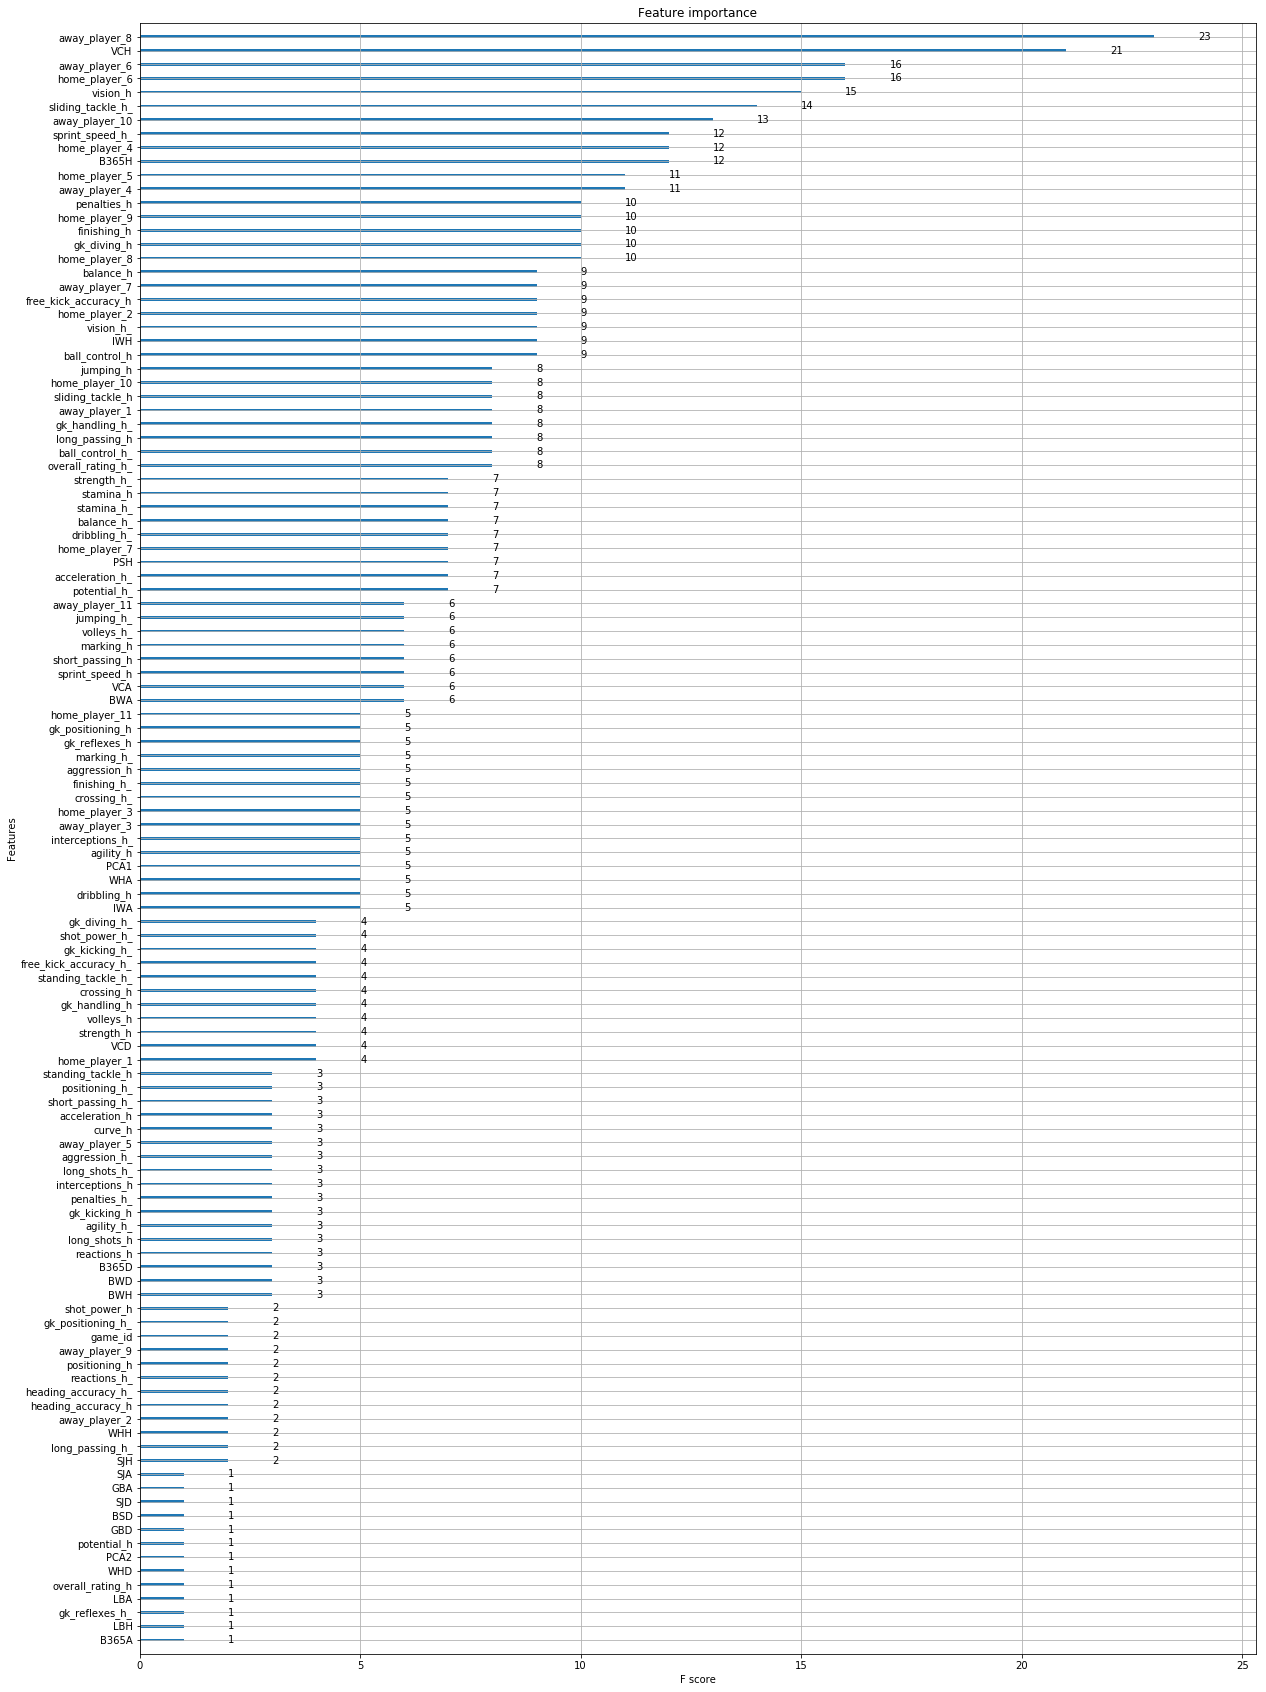

In [503]:
# plot feature importance
xgb_plot_importance(xgb_m,  figsize = (20,30))
plt.show()
pass

~ 20% features really importance

In [504]:
p = 55

#####  Binarizer

In [505]:
X_bin = Binarizer().fit_transform(scale(with_team_train))
selectChi2 = SelectPercentile(chi2, percentile=p).fit(X_bin, y_with_team)
selectF_classif = SelectPercentile(f_classif, percentile=p).fit(with_team_train, y_with_team)

In [506]:
chi2_selected = selectChi2.get_support()
chi2_selected_features = [ f for i,f in enumerate(with_team_train.columns) if chi2_selected[i]]
print('Chi2 selected {} features {}.'.format(chi2_selected.sum(),
   chi2_selected_features))

Chi2 selected 70 features ['home_player_1', 'home_player_2', 'home_player_3', 'home_player_4', 'home_player_5', 'home_player_6', 'home_player_7', 'home_player_8', 'home_player_9', 'home_player_10', 'home_player_11', 'B365H', 'B365D', 'B365A', 'BWH', 'BWD', 'BWA', 'IWH', 'IWA', 'LBH', 'LBA', 'PSH', 'PSA', 'WHH', 'WHA', 'SJH', 'SJA', 'VCH', 'VCD', 'VCA', 'GBA', 'BSA', 'acceleration_h', 'agility_h', 'ball_control_h', 'crossing_h', 'curve_h', 'dribbling_h', 'finishing_h', 'free_kick_accuracy_h', 'heading_accuracy_h', 'interceptions_h', 'long_passing_h', 'long_shots_h', 'overall_rating_h', 'penalties_h', 'positioning_h', 'potential_h', 'reactions_h', 'short_passing_h', 'shot_power_h', 'sprint_speed_h', 'stamina_h', 'vision_h', 'volleys_h', 'acceleration_h_', 'agility_h_', 'ball_control_h_', 'dribbling_h_', 'finishing_h_', 'long_passing_h_', 'long_shots_h_', 'positioning_h_', 'potential_h_', 'short_passing_h_', 'shot_power_h_', 'sprint_speed_h_', 'stamina_h_', 'volleys_h_', 'PCA1'].


In [507]:
f_classif_selected = selectF_classif.get_support()
f_classif_selected_features = [ f for i,f in enumerate(with_team_train.columns) if f_classif_selected[i]]
print('F_classif selected {} features {}.'.format(f_classif_selected.sum(),
   f_classif_selected_features))

F_classif selected 70 features ['home_player_1', 'home_player_2', 'home_player_3', 'home_player_4', 'home_player_5', 'home_player_6', 'home_player_7', 'home_player_8', 'home_player_9', 'home_player_10', 'home_player_11', 'away_player_7', 'away_player_8', 'away_player_10', 'B365H', 'B365A', 'BWH', 'BWA', 'IWH', 'IWA', 'LBH', 'LBA', 'PSH', 'PSA', 'WHH', 'WHA', 'SJH', 'SJA', 'VCH', 'VCA', 'GBH', 'GBA', 'BSH', 'BSA', 'acceleration_h', 'agility_h', 'ball_control_h', 'crossing_h', 'curve_h', 'dribbling_h', 'finishing_h', 'free_kick_accuracy_h', 'long_passing_h', 'long_shots_h', 'overall_rating_h', 'penalties_h', 'positioning_h', 'potential_h', 'reactions_h', 'short_passing_h', 'shot_power_h', 'sprint_speed_h', 'stamina_h', 'vision_h', 'volleys_h', 'acceleration_h_', 'agility_h_', 'ball_control_h_', 'curve_h_', 'dribbling_h_', 'finishing_h_', 'long_passing_h_', 'overall_rating_h_', 'potential_h_', 'reactions_h_', 'short_passing_h_', 'sprint_speed_h_', 'vision_h_', 'PCA1', 'PCA2'].


In [508]:
selected = chi2_selected & f_classif_selected
print('Chi2 & F_classif selected {} features'.format(selected.sum()))
features = [ f for f,s in zip(with_team_train.columns, selected) if s]
print (features)

Chi2 & F_classif selected 60 features
['home_player_1', 'home_player_2', 'home_player_3', 'home_player_4', 'home_player_5', 'home_player_6', 'home_player_7', 'home_player_8', 'home_player_9', 'home_player_10', 'home_player_11', 'B365H', 'B365A', 'BWH', 'BWA', 'IWH', 'IWA', 'LBH', 'LBA', 'PSH', 'PSA', 'WHH', 'WHA', 'SJH', 'SJA', 'VCH', 'VCA', 'GBA', 'BSA', 'acceleration_h', 'agility_h', 'ball_control_h', 'crossing_h', 'curve_h', 'dribbling_h', 'finishing_h', 'free_kick_accuracy_h', 'long_passing_h', 'long_shots_h', 'overall_rating_h', 'penalties_h', 'positioning_h', 'potential_h', 'reactions_h', 'short_passing_h', 'shot_power_h', 'sprint_speed_h', 'stamina_h', 'vision_h', 'volleys_h', 'acceleration_h_', 'agility_h_', 'ball_control_h_', 'dribbling_h_', 'finishing_h_', 'long_passing_h_', 'potential_h_', 'short_passing_h_', 'sprint_speed_h_', 'PCA1']


####  Try reduce the amount of parameters

In [560]:
X_sel = with_team_train[features]

X_train, X_test, y_train, y_test = \
            train_test_split(X_sel, y_with_team, random_state=1, stratify=y_with_team, test_size=0.4)

X_train, X_valid, y_train, y_valid = \
            train_test_split(X_sel, y_with_team, random_state=1, stratify=y_with_team, test_size=0.2)

In [510]:
xgb_sep = xgb_er_stop_fit(X_train, y_train, ear_stop_round = 250, eval_set=[(X_test, y_test)])

[0]	validation_0-auc:0.733451
Will train until validation_0-auc hasn't improved in 250 rounds.
[1]	validation_0-auc:0.735013
[2]	validation_0-auc:0.740087
[3]	validation_0-auc:0.741376
[4]	validation_0-auc:0.743223
[5]	validation_0-auc:0.74312
[6]	validation_0-auc:0.743631
[7]	validation_0-auc:0.745994
[8]	validation_0-auc:0.746859
[9]	validation_0-auc:0.747446
[10]	validation_0-auc:0.748827
[11]	validation_0-auc:0.74983
[12]	validation_0-auc:0.750027
[13]	validation_0-auc:0.750245
[14]	validation_0-auc:0.752178
[15]	validation_0-auc:0.753147
[16]	validation_0-auc:0.753433
[17]	validation_0-auc:0.75342
[18]	validation_0-auc:0.754593
[19]	validation_0-auc:0.755673
[20]	validation_0-auc:0.755734
[21]	validation_0-auc:0.756592
[22]	validation_0-auc:0.757193
[23]	validation_0-auc:0.758191
[24]	validation_0-auc:0.759166
[25]	validation_0-auc:0.760123
[26]	validation_0-auc:0.760589
[27]	validation_0-auc:0.761225
[28]	validation_0-auc:0.761559
[29]	validation_0-auc:0.762446
[30]	validation_0-

In [513]:
xgb_sep_pred_tr = xgb_model_pred(xgb_sep, X_train)
xgb_sep_pred_te = xgb_model_pred(xgb_sep, X_test)
xgb_sep_pred_val = xgb_model_pred(xgb_sep, X_valid)
#xgb_sep_pred_fin = xgb_model_pred(xgb_sep, train_with_team_test)

xgb_sep_proba_tr = xgb_model_pred_proba(xgb_sep, X_train)
xgb_sep_proba_te = xgb_model_pred_proba(xgb_sep, X_test)
xgb_sep_proba_val = xgb_model_pred_proba(xgb_sep, X_valid)
#xgb_sep_proba_fin = xgb_model_pred_proba(xgb_sep, train_with_team_test)

In [514]:
print('Predict')
roc_score_get(y_train, xgb_sep_pred_tr)
roc_score_get(y_test, xgb_sep_pred_te)
roc_score_get(y_valid, xgb_sep_pred_val)
print('Proba')
roc_score_get(y_train, xgb_sep_proba_tr)
roc_score_get(y_test, xgb_sep_proba_te)
roc_score_get(y_valid, xgb_sep_proba_val)

Predict
roc auc score:  0.7198255984213608
roc auc score:  0.6873682562407998
roc auc score:  0.6553112236741241
Proba
roc auc score:  0.8273070115058925
roc auc score:  0.7850671717969386
roc auc score:  0.7396913520360409


### Prepare final data 

In [515]:
test_normalized = normalize(train_with_team_test, axis=0)
pca = PCA(n_components=2)
test_pca = pca.fit_transform(test_normalized)
train_with_team_test['PCA1'] = test_pca[:,0]
train_with_team_test['PCA2'] = test_pca[:,1]
sel_test = train_with_team_test[features]    

In [520]:
xgb_sep_proba_fin = xgb_sep.predict_proba(sel_test, ntree_limit=xgb_sep.best_iteration)[:,1]

### Try use this (bad,  Only 0.73 on final(mines 0.05) 

https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

####  Learn with CV


In [283]:
def modelfit(alg, dtrain, predictors, target_col, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)#, show_progress=False)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target_col],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : %.4g" % accuracy_score(dtrain[target_col].values, dtrain_predictions))
    print ("AUC Score (Train): %f" % roc_auc_score(dtrain[target_col], dtrain_predprob))
                    
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances', figsize=(30, 20))
    plt.ylabel('Feature Importance Score')

In [255]:
with_team_train = train_with_team_c[:]
with_team_test = train_with_team_test_c[:]

target = 'win_team'


Model Report
Accuracy : 0.7572
AUC Score (Train): 0.832301


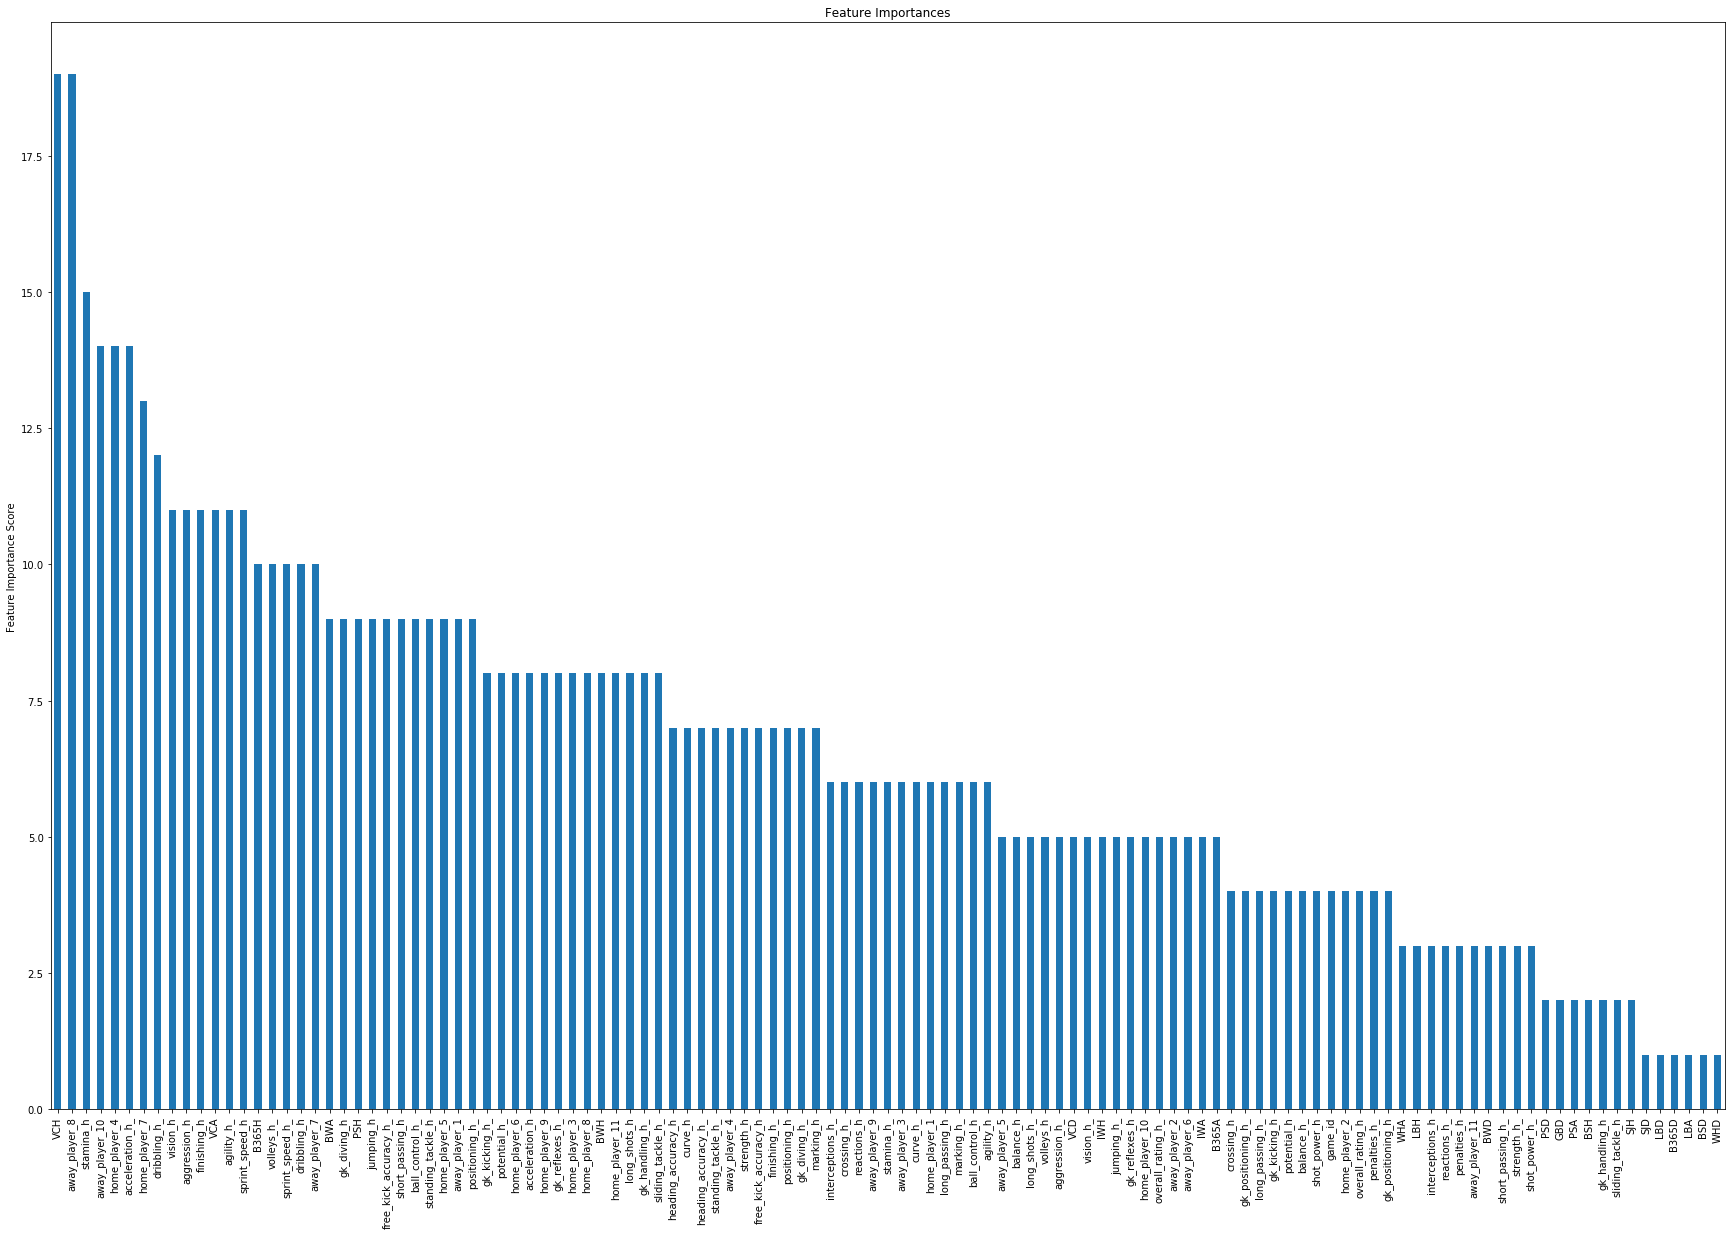

In [284]:
#Choose all predictors except target & IDcols
predictors = [x for x in with_team_train.columns if x not in [target]]
xgb1 = xgb.XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb1, with_team_train, predictors, target)

In [287]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

gsearch1.fit(with_team_train[predictors], with_team_train[target])
pass

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=140,
       n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=0.8),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'max_depth': range(3, 10, 2), 'min_child_weight': range(1, 6, 2)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [332]:
print(gsearch1.best_params_, gsearch1.best_score_)
pd.DataFrame(gsearch1.cv_results_)[['mean_test_score', 'std_test_score', 'params']].head(10)

{'gamma': 0.004} 0.7611968519795121


,mean_test_score,std_test_score,params
0,0.761195,0.009481,{'gamma': 0.003}
1,0.761195,0.009481,{'gamma': 0.0035}
2,0.761197,0.009481,{'gamma': 0.004}
3,0.761197,0.009481,{'gamma': 0.0045000000000000005}


### Next Params, we need the following range

In [314]:
param_test1 = {
 'max_depth': [1,2,3],
 'min_child_weight':[2,3,4]
}
gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

gsearch1.fit(with_team_train[predictors], with_team_train[target])
pass

In [315]:
print(gsearch1.best_params_, gsearch1.best_score_)
pd.DataFrame(gsearch1.cv_results_)[['mean_test_score', 'std_test_score', 'params']].head(15)

{'max_depth': 2, 'min_child_weight': 3} 0.7611949389852251


,mean_test_score,std_test_score,params
0,0.758262,0.009975,"{'max_depth': 1, 'min_child_weight': 2}"
1,0.758262,0.009975,"{'max_depth': 1, 'min_child_weight': 3}"
2,0.758253,0.009963,"{'max_depth': 1, 'min_child_weight': 4}"
3,0.761175,0.010117,"{'max_depth': 2, 'min_child_weight': 2}"
4,0.761195,0.009481,"{'max_depth': 2, 'min_child_weight': 3}"
5,0.760922,0.010314,"{'max_depth': 2, 'min_child_weight': 4}"
6,0.758181,0.010512,"{'max_depth': 3, 'min_child_weight': 2}"
7,0.757794,0.010236,"{'max_depth': 3, 'min_child_weight': 3}"
8,0.757905,0.010779,"{'max_depth': 3, 'min_child_weight': 4}"


## Tune Gamma

In [316]:
param_test1 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=2,
 min_child_weight=3, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

gsearch1.fit(with_team_train[predictors], with_team_train[target])
pass

In [317]:
print(gsearch1.best_params_, gsearch1.best_score_)
pd.DataFrame(gsearch1.cv_results_)[['mean_test_score', 'std_test_score', 'params']].head(15)

{'gamma': 0.1} 0.7611968519795121


,mean_test_score,std_test_score,params
0,0.761195,0.009481,{'gamma': 0.0}
1,0.761197,0.009481,{'gamma': 0.1}
2,0.761197,0.009481,{'gamma': 0.2}
3,0.761197,0.009481,{'gamma': 0.3}
4,0.761197,0.009481,{'gamma': 0.4}


### Next Params, we need the following range

In [318]:
param_test1 = {
 'gamma': np.arange(0.1, 0.5, 0.1)
}
gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=2,
 min_child_weight=3, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

gsearch1.fit(with_team_train[predictors], with_team_train[target])
pass

In [319]:
print(gsearch1.best_params_, gsearch1.best_score_)
pd.DataFrame(gsearch1.cv_results_)[['mean_test_score', 'std_test_score', 'params']].head(15)

{'gamma': 0.1} 0.7611968519795121


,mean_test_score,std_test_score,params
0,0.761197,0.009481,{'gamma': 0.1}
1,0.761197,0.009481,{'gamma': 0.2}
2,0.761197,0.009481,{'gamma': 0.30000000000000004}
3,0.761197,0.009481,{'gamma': 0.4}


### Next Params, we need the following range

In [320]:
param_test1 = {
 'gamma': np.arange(0.07, 0.12, 0.01)
}
gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=2,
 min_child_weight=3, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

gsearch1.fit(with_team_train[predictors], with_team_train[target])
pass

In [321]:
print(gsearch1.best_params_, gsearch1.best_score_)
pd.DataFrame(gsearch1.cv_results_)[['mean_test_score', 'std_test_score', 'params']].head(15)

{'gamma': 0.07} 0.7611968519795121


,mean_test_score,std_test_score,params
0,0.761197,0.009481,{'gamma': 0.07}
1,0.761197,0.009481,{'gamma': 0.08}
2,0.761197,0.009481,{'gamma': 0.09}
3,0.761197,0.009481,{'gamma': 0.09999999999999999}
4,0.761197,0.009481,{'gamma': 0.10999999999999999}


### Next Params, we need the following range

In [328]:
param_test1 = {
 'gamma': np.arange(0.003, 0.005, 0.0005)
}
gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=2,
 min_child_weight=3, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

gsearch1.fit(with_team_train[predictors], with_team_train[target])
pass

In [329]:
print(gsearch1.best_params_, gsearch1.best_score_)
pd.DataFrame(gsearch1.cv_results_)[['mean_test_score', 'std_test_score', 'params']].head(15)

{'gamma': 0.004} 0.7611968519795121


,mean_test_score,std_test_score,params
0,0.761195,0.009481,{'gamma': 0.003}
1,0.761195,0.009481,{'gamma': 0.0035}
2,0.761197,0.009481,{'gamma': 0.004}
3,0.761197,0.009481,{'gamma': 0.0045000000000000005}


### Re-calibrate numbers of boosting


Model Report
Accuracy : 0.7572
AUC Score (Train): 0.832301


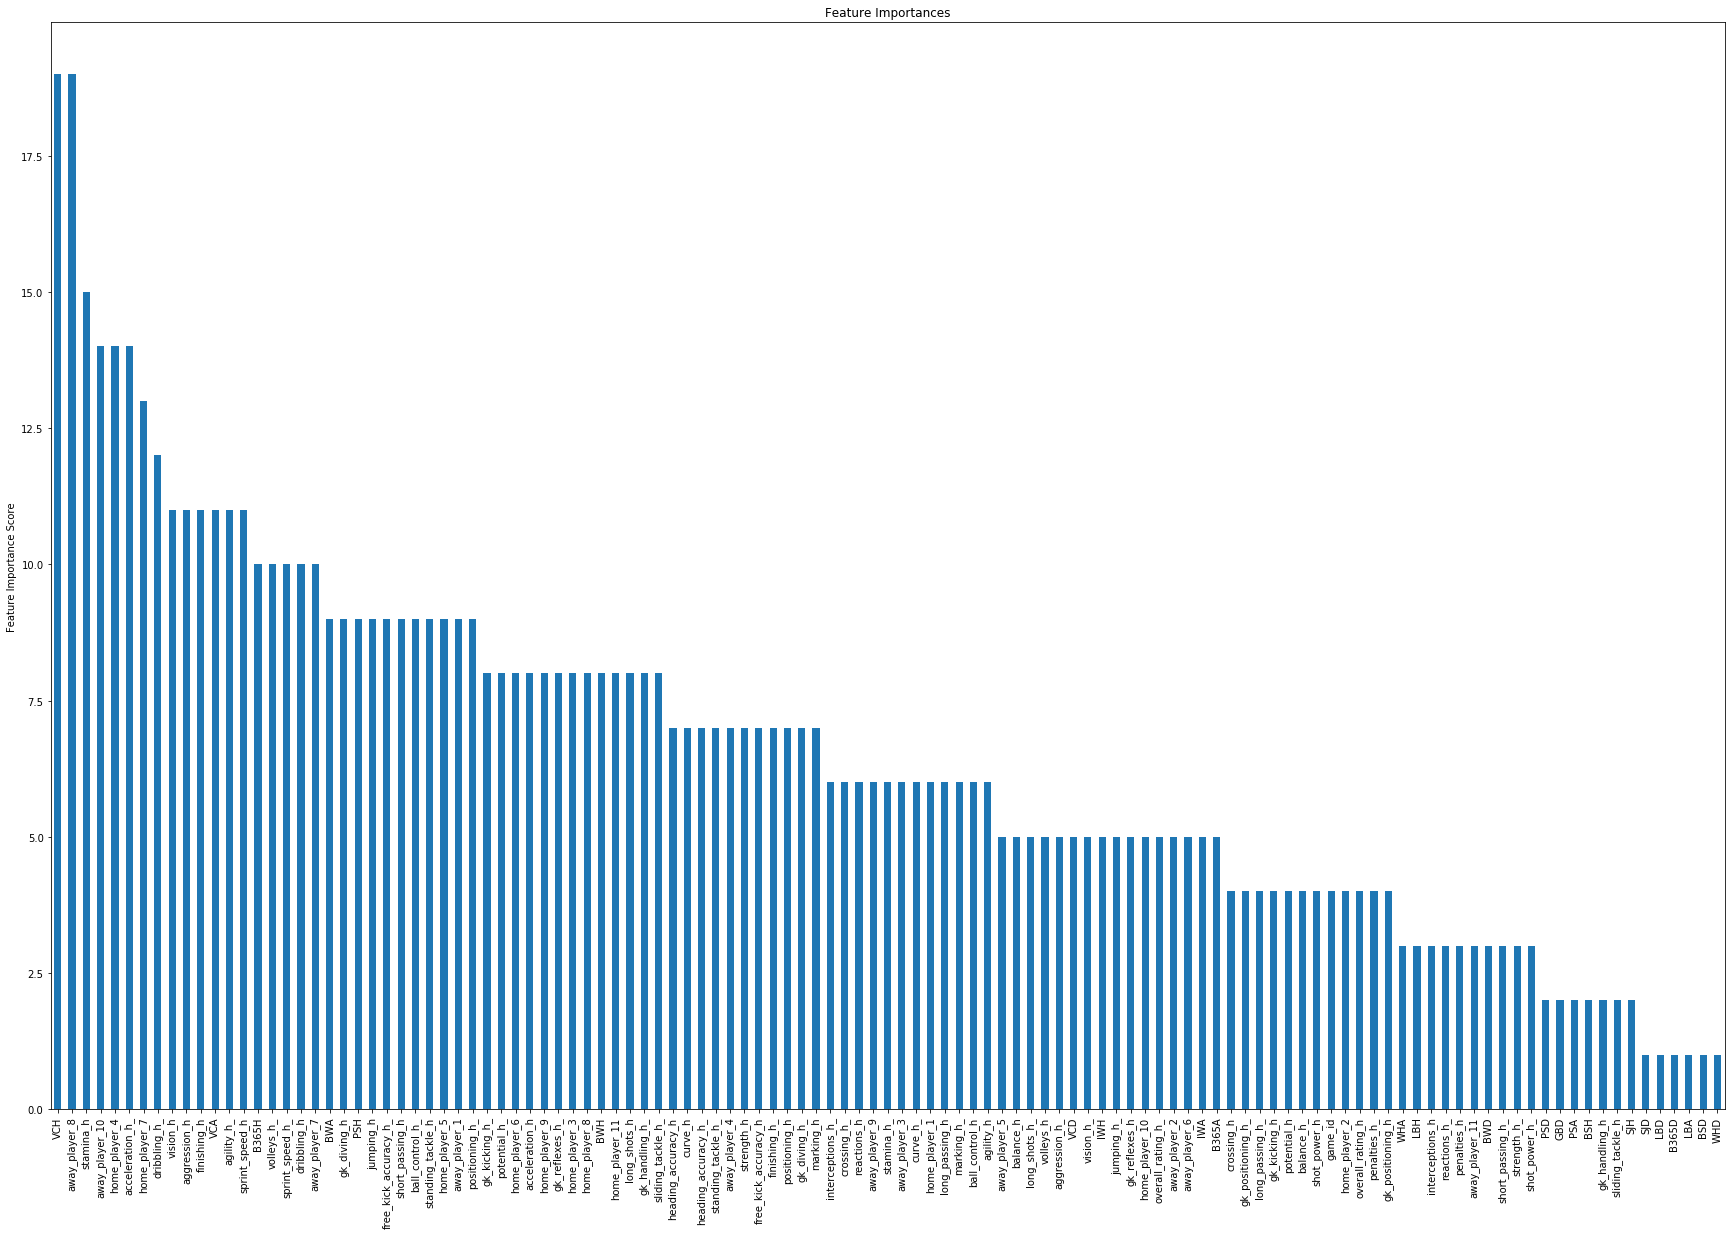

In [363]:
xgb2 = xgb.XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=2,
 min_child_weight=3,
 gamma=0.004,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb1, with_team_train, predictors, target)

#### FInals parameters:
|Param | value |
|------|------|
| gamma | 0.004  |
| max_depth | 2 | 
| min_child_weight | 3 | 

## Tune subsample and colsample_bytree

In [340]:
param_test1 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=2,
 min_child_weight=3, gamma=0.004, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

gsearch1.fit(with_team_train[predictors], with_team_train[target])
pass

In [343]:
print(gsearch1.best_params_, gsearch1.best_score_)
pd.DataFrame(gsearch1.cv_results_)[['mean_test_score', 'std_test_score', 'params']].head(17)

{'colsample_bytree': 0.8, 'subsample': 0.7} 0.7623618127433605


,mean_test_score,std_test_score,params
0,0.761100,0.008565,"{'colsample_bytree': 0.6, 'subsample': 0.6}"
1,0.761587,0.011197,"{'colsample_bytree': 0.6, 'subsample': 0.7}"
2,0.760189,0.009930,"{'colsample_bytree': 0.6, 'subsample': 0.8}"
3,0.759891,0.011149,"{'colsample_bytree': 0.6, 'subsample': 0.9}"
4,0.761200,0.009099,"{'colsample_bytree': 0.7, 'subsample': 0.6}"
5,0.761578,0.010348,"{'colsample_bytree': 0.7, 'subsample': 0.7}"
6,0.760050,0.010798,"{'colsample_bytree': 0.7, 'subsample': 0.8}"
7,0.759513,0.010045,"{'colsample_bytree': 0.7, 'subsample': 0.9}"
8,0.761185,0.009665,"{'colsample_bytree': 0.8, 'subsample': 0.6}"
9,0.762362,0.010166,"{'colsample_bytree': 0.8, 'subsample': 0.7}"


### Next Params, we need the following range

In [350]:
param_test1 = {
 'subsample':[i/100.0 for i in range(65,80,5)],
 'colsample_bytree':[i/100.0 for i in range(70,80,5)]
}
gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=2,
 min_child_weight=3, gamma=0.004, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

gsearch1.fit(with_team_train[predictors], with_team_train[target])
pass

In [349]:
print(gsearch1.best_params_, gsearch1.best_score_)
pd.DataFrame(gsearch1.cv_results_)[['mean_test_score', 'std_test_score', 'params']].head(17)

{'colsample_bytree': 0.75, 'subsample': 0.65} 0.7623804599907149


,mean_test_score,std_test_score,params
0,0.761200,0.009099,"{'colsample_bytree': 0.7, 'subsample': 0.6}"
1,0.761199,0.009851,"{'colsample_bytree': 0.7, 'subsample': 0.65}"
2,0.761578,0.010348,"{'colsample_bytree': 0.7, 'subsample': 0.7}"
3,0.760636,0.008598,"{'colsample_bytree': 0.75, 'subsample': 0.6}"
4,0.762380,0.008518,"{'colsample_bytree': 0.75, 'subsample': 0.65}"
5,0.761460,0.009541,"{'colsample_bytree': 0.75, 'subsample': 0.7}"


#### FInals parameters:
|Param | value |
|------|------|
| gamma | 0.004  |
| max_depth | 2 | 
| min_child_weight | 3 | 
|colsample_bytree| 0.75|
|subsample| 0.65

##  Tuning Regularization Parameters

In [351]:
param_test1 = {
 'reg_alpha': [1e-5, 1e-2, 0.1, 1, 100]
}
gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=2,
 min_child_weight=3, gamma=0.004, subsample=0.65, colsample_bytree=0.75,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

gsearch1.fit(with_team_train[predictors], with_team_train[target])
pass

In [352]:
print(gsearch1.best_params_, gsearch1.best_score_)
pd.DataFrame(gsearch1.cv_results_)[['mean_test_score', 'std_test_score', 'params']].head(17)

{'reg_alpha': 1e-05} 0.7623804599907149


,mean_test_score,std_test_score,params
0,0.762380,0.008518,{'reg_alpha': 1e-05}
1,0.762368,0.008783,{'reg_alpha': 0.01}
2,0.761742,0.009114,{'reg_alpha': 0.1}
3,0.761577,0.009498,{'reg_alpha': 1}
4,0.751898,0.011161,{'reg_alpha': 100}


### Next Params, we need the following range

In [359]:
param_test1 = {
 'reg_alpha': np.arange(5e-6, 1.1e-5, 1e-6)
}
gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=2,
 min_child_weight=3, gamma=0.004, subsample=0.65, colsample_bytree=0.75,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

gsearch1.fit(with_team_train[predictors], with_team_train[target])
pass

In [360]:
print(gsearch1.best_params_, gsearch1.best_score_)
pd.DataFrame(gsearch1.cv_results_)[['mean_test_score', 'std_test_score', 'params']].head(17)

{'reg_alpha': 5e-06} 0.7623804599907149


,mean_test_score,std_test_score,params
0,0.76238,0.008518,{'reg_alpha': 5e-06}
1,0.76238,0.008518,{'reg_alpha': 6e-06}
2,0.76238,0.008518,{'reg_alpha': 7e-06}
3,0.76238,0.008518,{'reg_alpha': 8e-06}
4,0.76238,0.008518,{'reg_alpha': 8.999999999999999e-06}
5,0.76238,0.008518,{'reg_alpha': 9.999999999999999e-06}


#### FInals parameters:
|Param | value |
|------|------|
| gamma | 0.004  |
| max_depth | 2 | 
| min_child_weight | 3 | 
|colsample_bytree| 0.75|
|subsample| 0.65|
|reg_alpha | 5e-06|

### Re-calibrate numbers of boosting


Model Report
Accuracy : 0.7572
AUC Score (Train): 0.832301


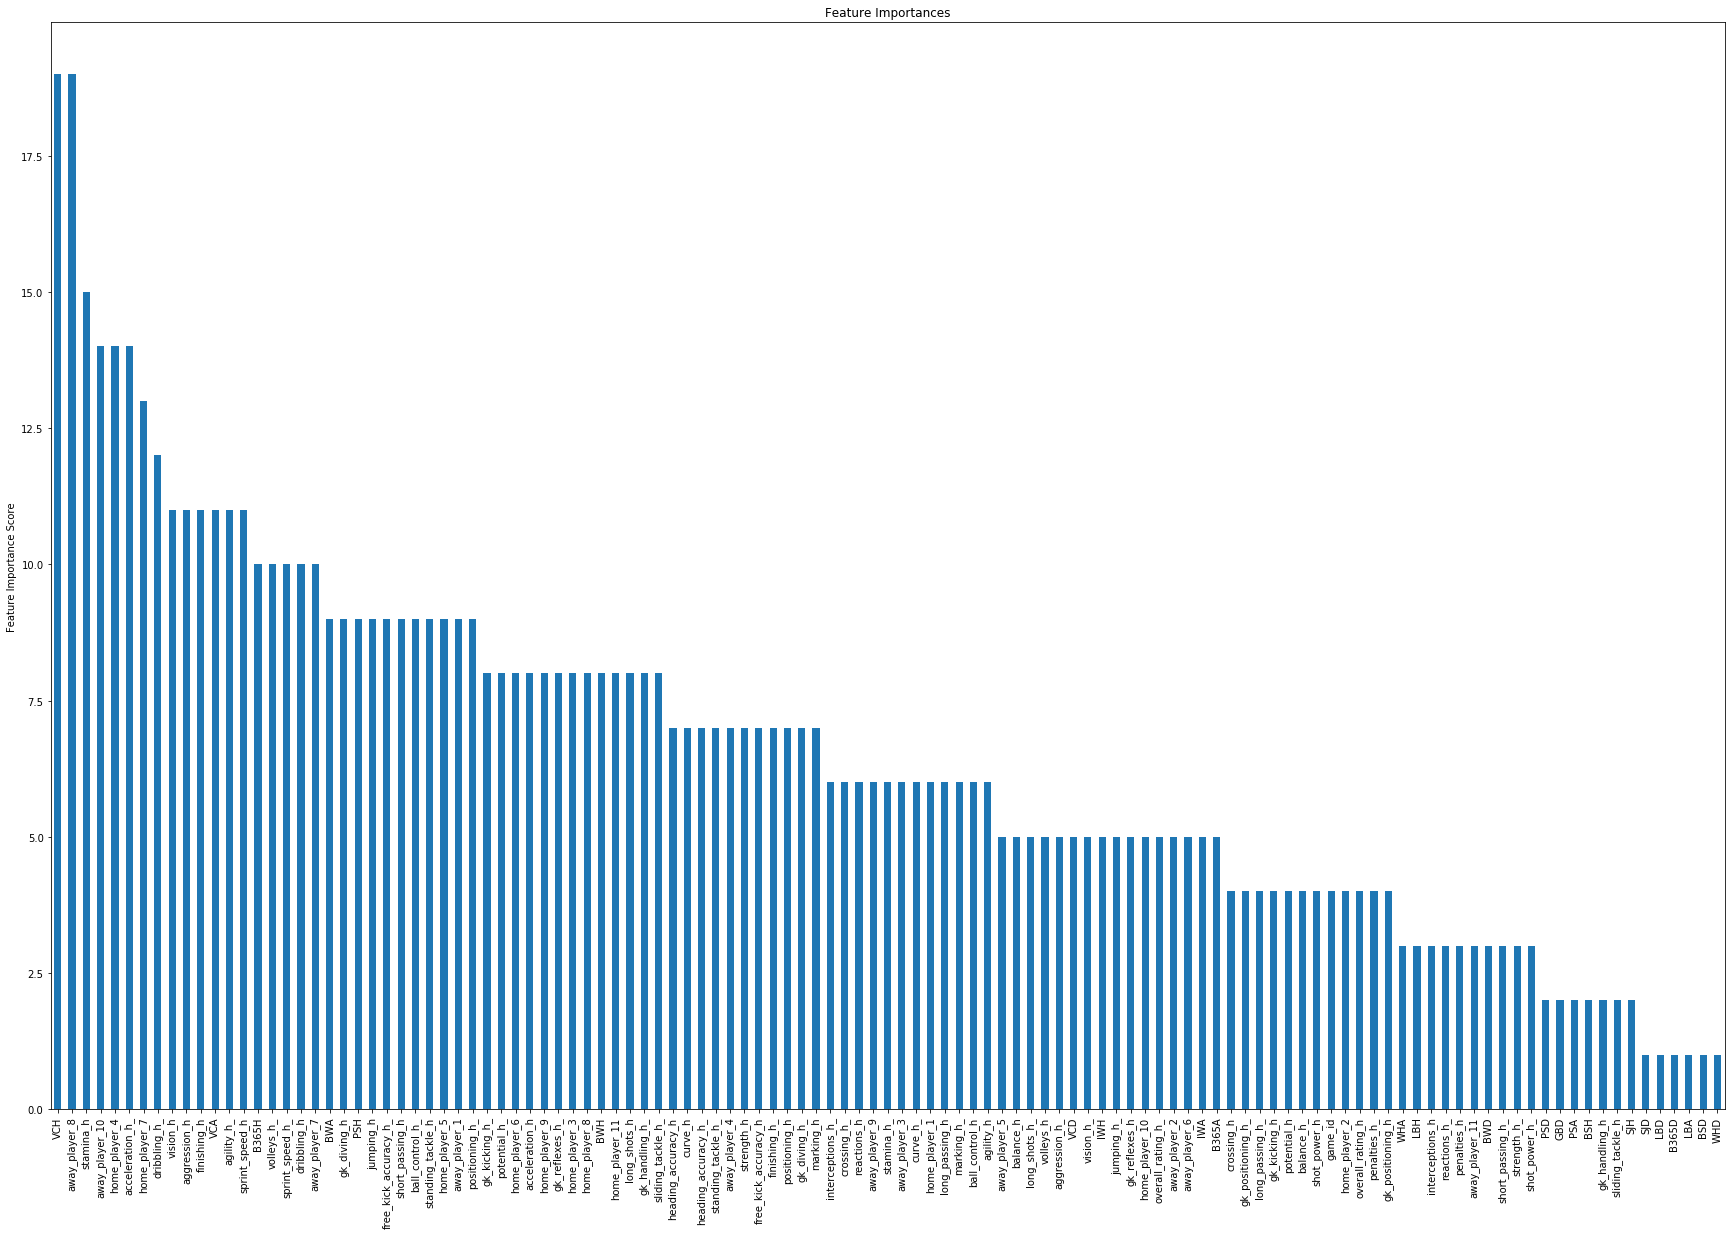

In [362]:
xgb2 = xgb.XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=2,
 min_child_weight=3,
 gamma=0.004,
 subsample=0.65,
 colsample_bytree=0.75,
 reg_alpha=5e-06,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb1, with_team_train, predictors, target)

## Reducing Learning Rate


Model Report
Accuracy : 0.7572
AUC Score (Train): 0.832301


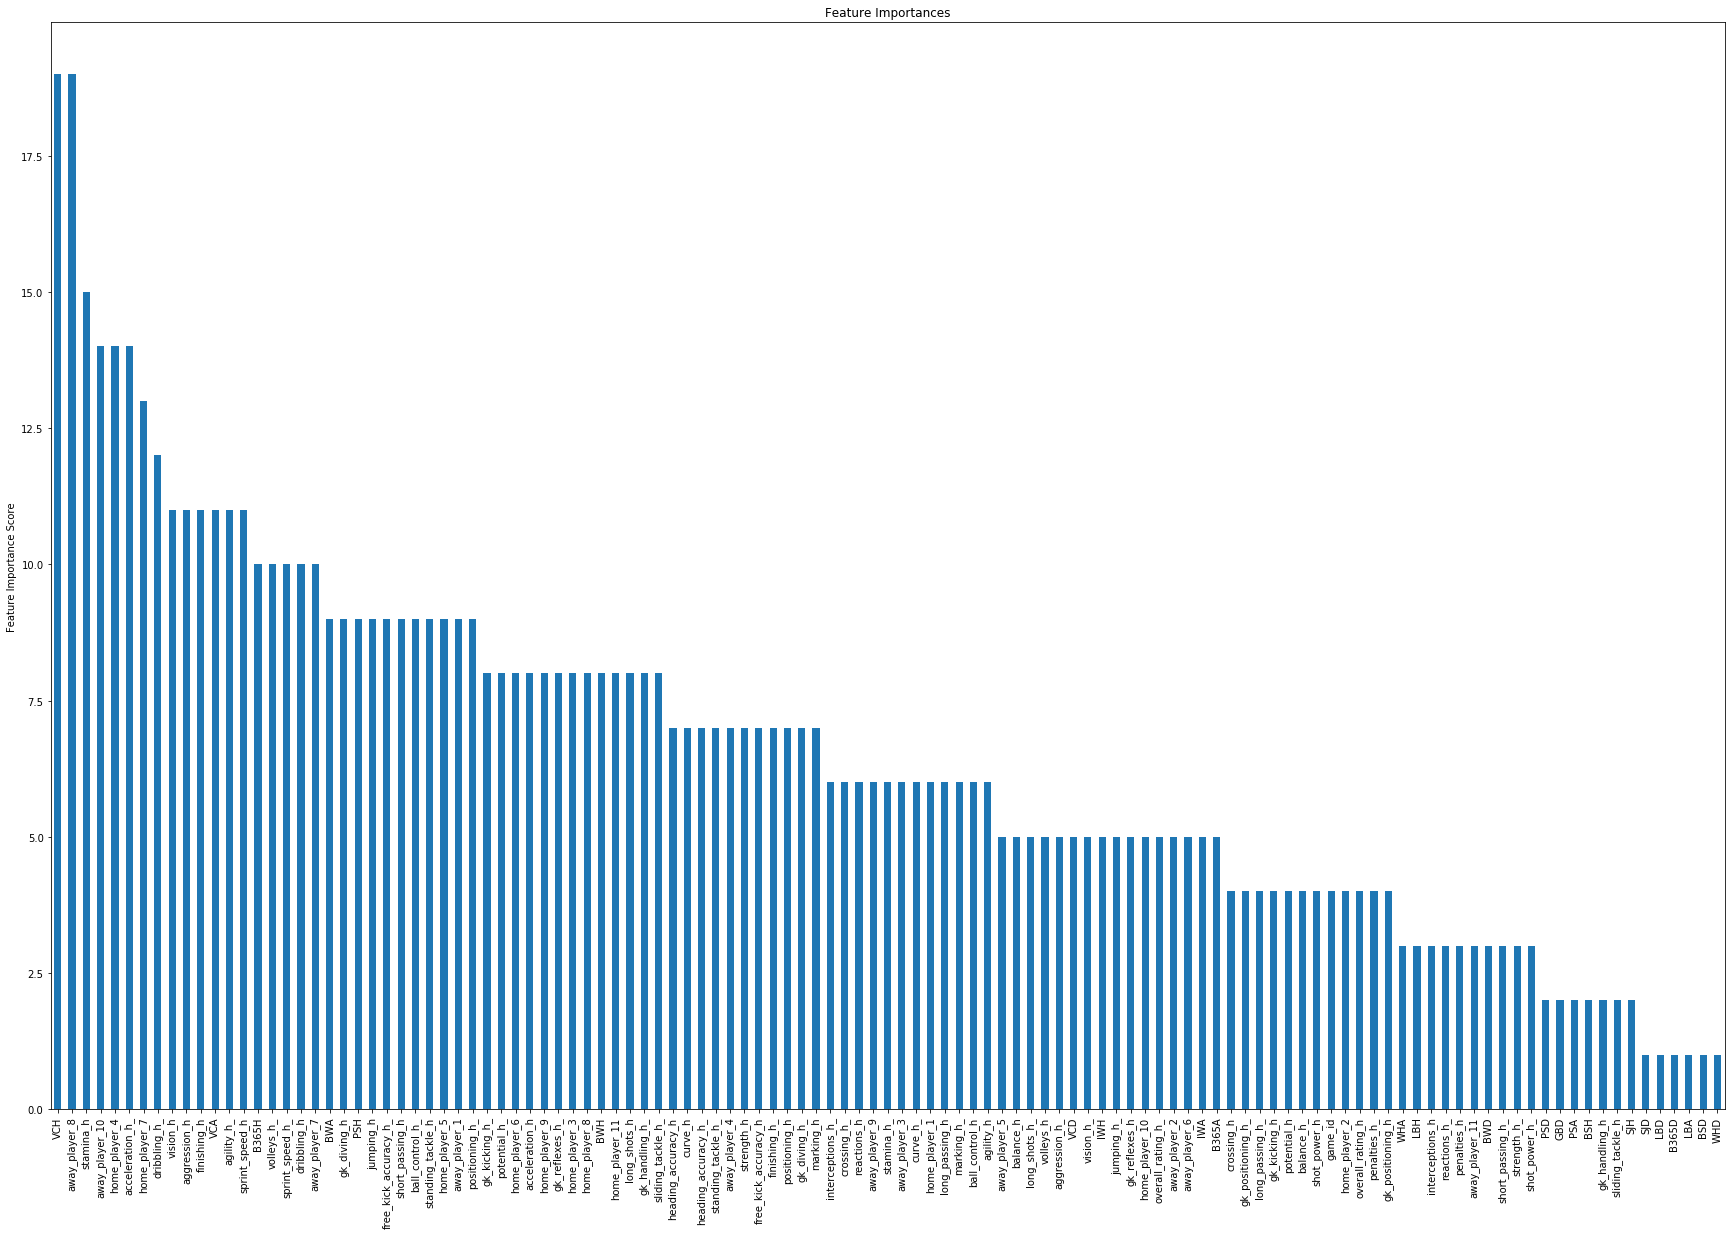

In [368]:
xgb2 = xgb.XGBClassifier(
 learning_rate =0.1,
 n_estimators=5000,
 max_depth=2,
 min_child_weight=3,
 gamma=0.004,
 subsample=0.65,
 colsample_bytree=0.75,
 reg_alpha=5e-06,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb1, with_team_train, predictors, target)

##  Let's try apply it to the xgb 

In [369]:
xgb_tree_tune = xgb.XGBClassifier(
                             learning_rate =0.1,
                             n_estimators=5000,
                             max_depth=2,
                             min_child_weight=3,
                             gamma=0.004,
                             subsample=0.65,
                             colsample_bytree=0.75,
                             reg_alpha=5e-06,
                             objective= 'binary:logistic',
                             nthread=4,
                             scale_pos_weight=1,
                             seed=27)

xgb_tree_tune.fit(X_train_wt, Y_train_wt, n_jobs=-1)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.75, gamma=0.004, learning_rate=0.1,
       max_delta_step=0, max_depth=2, min_child_weight=3, missing=None,
       n_estimators=5000, n_jobs=1, nthread=4, objective='binary:logistic',
       random_state=0, reg_alpha=5e-06, reg_lambda=1, scale_pos_weight=1,
       seed=27, silent=True, subsample=0.65)

In [377]:
xgb_tune_pred_tr = xgb_model_pred(xgb_tree_tune, X_train_wt)
xgb_tune_pred_te = xgb_model_pred(xgb_tree_tune, X_test_wt)
xgb_tune_pred_val = xgb_model_pred(xgb_tree_tune, X_valid_wt)

xgb_tune_proba_tr = xgb_model_pred_proba(xgb_tree_tune, X_train_wt)
xgb_tune_proba_te = xgb_model_pred_proba(xgb_tree_tune, X_test_wt)
xgb_tune_proba_val = xgb_model_pred_proba(xgb_tree_tune, X_valid_wt)

xgb_tune_proba_fin = xgb_model_pred_proba(xgb_tree_tune, train_with_team_test)

In [378]:
print('Predict')
roc_score_get(Y_train_wt, xgb_tune_pred_tr)
roc_score_get(Y_test_wt, xgb_tune_pred_te)
roc_score_get(Y_valid_wt, xgb_tune_pred_val)
print('Predict_proba')
roc_score_get(Y_train_wt, xgb_tune_proba_tr)
roc_score_get(Y_test_wt, xgb_tune_proba_te)
roc_score_get(Y_valid_wt, xgb_tune_proba_val)

Predict
roc auc score:  1.0
roc auc score:  0.6515691776855188
roc auc score:  0.6618237280657095
Predict_proba
roc auc score:  1.0
roc auc score:  0.7226626447686617
roc auc score:  0.7204205274411974


## Output data

In [571]:
#final_data = pd.DataFrame(np.vstack((df_test_fe.index, xgb_m_wt_proba_fin)).T)
final_data = pd.DataFrame(xgb_es_wt_proba_fin.T, index = df_test_fe.index)
#final_data.columns = ['id', 'win_team']
final_data.columns = ['win_team']
final_data.head(1)

,win_team
id,
0,0.675765


In [572]:
final_data.to_csv('FootballCompetition_05.05.2018_13:21.csv', index='False')
final_data.head()

,win_team
id,
0,0.675765
1,0.927562
2,0.523276
3,0.383117
4,0.256088
